_Author: Maurice Snoeren_<br>
Within this notebook we investigate how learning or training of a network occurs. We use the backpropagation theory and the optimizer gradient descent. The classes provided in the directory "python" are used here. For transparancy these classes have been copied.

In [32]:
# file: ann.py
import numpy as np
import matplotlib as plt

# Author: Maurice Snoeren - Avans Hogeschool - mac.snoeren@avans.nl
# 09-2020 - Beta version

class ANN:
    """ Artificial Neural Network class.
        This class implements a ANN with hidden layers to understand how a network is working under the hood.
    """

    def __init__(self, num_input_nodes, num_output_nodes, output_activation):
        """Constructor for the ANN. 
            num_input_nodes (int): Number of inputs
            num_output_nodes (int): Number of outputs
        """
        self.num_input_nodes   = num_input_nodes
        self.num_output_nodes  = num_output_nodes
        self.output_activation = output_activation
        self.hidden_layers     = [] # Holds the hidden_layer classes
        self.Wy                = np.random.rand(num_input_nodes, num_output_nodes) # Hold output layer weight matrix
        self.by                = np.random.rand(num_output_nodes) # Biases vector of the output nodes
        self.x                 = [] # Hold the input vector
        self.zy                = [] # Hold the summation of the input and bias with the weights
        self.y                 = [] # hold the output vector

    def get_weight_matrix(self):
        return self.Wy

    def set_weight_matrix(self, Wy):
        self.Wy = Wy

    def get_biases_vector(self):
        return self.by

    def set_biases_vector(self, by):
        self.by = by

    def add_hidden_layer(self, hidden_layer):
        self.hidden_layers.append(hidden_layer)
        self.Wy = np.random.rand(hidden_layer.num_hidden_nodes, self.num_output_nodes)

    def get_total_hidden_layers(self):
        return len(self.hidden_layers)

    def get_hidden_layer(self, i):
        if ( i < len(self.hidden_layers)):
            return self.hidden_layers[i]

        else:
            print("get_hidden_layer: error no layer found!")
            return -1

    def forward_propagation(self, x):
        """Calculate the output vector y of the neural network based on the x and hidden layers."""
        self.x = x
#        print("Forward propagation\nInput layer vector: " + str(x))

        if ( len(self.hidden_layers) == 0):
            self.zy = np.dot( self.x, self.Wy ) + self.by
            self.y = self.output_activation.forward( self.zy )

        else: # Loop over the hidden layers
            input_vector = self.x
            for hidden_layer in self.hidden_layers:
                output_vector = hidden_layer.forward_propagation(input_vector)
#                print("Hidden layer output vector: " + str(output_vector))
                input_vector = output_vector

            self.zy = np.dot( input_vector, self.Wy ) + self.by
            self.y  = self.output_activation.forward( self.zy )
#            print("Output layer vector: " + str(self.y))

        return self.y
        
    def back_propagation(self, input_example, output_desired):
        """Perform calculation the network backwards"""

        self.forward_propagation(input_example)  # Perform first the forward propagation calculation

        J = 0.5 * ( self.y - output_desired )**2 # Calculate the cost
#        print("Backward propagation\nJ = " + str(J))

        dJ_dy = ( self.y - output_desired )
#        print("dJ_dy   : " + str(dJ_dy))
        dy_dzy   = self.output_activation.derivative( self.zy )
#        print("dy_dzy  : " + str(dy_dzy))
        delta = np.multiply( dJ_dy, dy_dzy ) # required to back propagate through the network (part of the derivation that propagates back into the network)
#        print("delta: " + str(delta))
        weights = self.Wy
        dJ_dWh = [] # Hold the weight gradients of the hidden layers

        if ( len(self.hidden_layers) == 0):
            dJ_dWy = np.dot( self.x.transpose(), delta )
#            print("dJ_dWy  : " + str(dJ_dWy))

        else: # Loop over the hidden layers from back to start
            dzy_dWy = self.hidden_layers[ len(self.hidden_layers)-1 ].h
#            print("dzy_dWy : " + str(dzy_dWy))
            dJ_dWy = np.dot( dzy_dWy.transpose(), delta )
#            print("dJ_dWy  : " + str(dJ_dWy))

            dJ_dWh = []
            for hidden_layer in reversed(self.hidden_layers):
                result  = hidden_layer.back_propagation(delta, weights)
                delta   = result['delta']
                weights = result['W']
                dJ_dWh.append( result['dJ_dWh'])

        return {'dJ_dWh': list(reversed(dJ_dWh)), 'dJ_dWy': dJ_dWy, 'J': np.sum(J) }

    def __str__(self):
        info = "ANN(inputs: " + str(self.num_input_nodes) + ", outputs: " + str(self.num_output_nodes) + ", hidden layers: " + str(len(self.hidden_layers)) + ")\n"
        for i in range( len(self.hidden_layers) ):
            info += " Hidden layer " + str(i+1) + ": " + str(self.hidden_layers[i])
        info += "Weight Matrix: \n" + str(self.Wy) + "\n"
        info += "Biases Vector: \n" + str(self.by) + "\n"
        info += "Output activation function: " + str(self.output_activation)
        return info

class ANN_Hidden_Layer:
    """ Artificial Neural Network Hidden Layer class.
    """

    def __init__(self, num_input_nodes, num_hidden_nodes, activation):
        """Constructor for the ANN. 
            num_input_nodes (int): Number of inputs
            num_output_nodes (int): Number of outputs
        """
        self.num_input_nodes  = num_input_nodes
        self.num_hidden_nodes = num_hidden_nodes
        self.activation       = activation
        self.x                = [] # Input vector of this hidden layer
        self.Wh               = np.random.rand(num_input_nodes, num_hidden_nodes) # Hidden Weight Matrix
        self.bh               = np.random.rand(num_hidden_nodes)                  # Biases vector
        self.zh               = [] # Hold the summation of the input and bias with the weights
        self.h                = [] # Hold the output vector of this hidden layer

    def get_weight_matrix(self):
        return self.Wh

    def set_weight_matrix(self, Wh):
        self.Wh = Wh

    def get_biases_vector(self):
        return self.bh

    def set_biases_vector(self, bh):
        self.bh = bh

    def forward_propagation(self, x):
        """Calculate the output vector y of the neural network based on the x and hidden layers."""
        self.x = x
#        print("input vector (x): " + str(self.x))
        self.zh = np.dot(x, self.Wh) + self.bh
#        print("zh: " + str(self.zh))
        self.h  = self.activation.forward( self.zh )
        return self.h

    def back_propagation(self, prev_delta, prev_W):
        """Part of the back propagation calculation of the ANN network"""
#        print("Hidden Layer Back Prop")   
        # delta = dJ_dy * dy_dzy => zy output previous layer

#        print("prev_delta: " + str(prev_delta))
#        print("prev_W: " + str(prev_W))

        delta2 = np.dot( prev_delta, prev_W.transpose() ) * self.activation.derivative( self.zh )
#        print("delta2: " + str(delta2))

        #dz1_dWh = self.h # This is not correct and it should be the activation from the previous layer
        dz1_dWh = self.x # Activation from the previous layer!
#        print("dz1_dWh: " + str(dz1_dWh))
        dJ_dWh  = np.dot( dz1_dWh.transpose(), delta2 )
#        print("dJ_dWh  : " + str(dJ_dWh))

        return { 'delta': delta2, 'W': self.Wh, 'dJ_dWh': dJ_dWh }

    def __str__(self):
        info = "(inputs: " + str(self.num_input_nodes) + ", nodes: " + str(self.num_hidden_nodes) + ", activation: " + str(self.activation) + ")\n"
        info += "  Weight Matrix: \n" + str(self.Wh) + "\n"
        info += "  Biases Vector: \n" + str(self.bh) + "\n"
        return info


In [33]:
# file: ann_af.py
import numpy as np
import matplotlib as plt
from random import random

# Author: Maurice Snoeren - Avans Hogeschool - mac.snoeren@avans.nl
# 09-2020 - Beta version

class ANN_Activation:
    """ Artificial Neural Network activation function class.
        This class implements the base class of the activation function. It implements the
        activation function and the derivative function of the activation function.
    """

    def __init__(self):
        """Constructor for the ANN_Activation."""
        pass

    def forward(self, input_vector):
        """Forward function of the activation function."""
#        print("ABNN_Activation base class!")
        return input_vector

    def derivative(self, input_vector): 
        """Derivative of the function, used by the back propagation algorithm."""
#        print("ABNN_Activation base class!")
        return input_vector        

class ANN_Sigmoid_Activation(ANN_Activation):
    """ Artificial Neural Network signoid activation function class.
    """

    def __init__(self):
        """Constructor for the ANN_Sigmoid_Activation."""
        pass

    def forward(self, input_vector):
        return 1/(1 + np.exp(-input_vector)) 

    def derivative(self, input_vector): 
#        print("input: " + str(input_vector))
        return np.exp(-input_vector) / ((1 + np.exp(-input_vector))**2)

    def __str__(self):
        return "Sigmoid activation function"

## Training
In the following code, we try out different learning rates and iterations to see what we could expect. Investigate the outcome of the results. What you see here also happens during training of more complex ANN's. So, make sure you take into account all these different types of behaviour. You will see, that even in the case we train very very long, it is possible that the ANN does not make any progress. However, when the ANN starts in a different (random weights and biases) position, it is possible it gets good results! That makes things somethimes very complex. My advice: Always save the weights and biases and only discard results when you find improvements. I see too many students not saving any weights and biases and are not able to get the good results back.

The following code provide two functions to get examples for training a simple neural network with **one** training example. Just to see how learning occurs.

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def train_ann_example(alpha, iterations):
    sa  = ANN_Sigmoid_Activation()
    ann = ANN(4, 2, sa)
    ann.add_hidden_layer(ANN_Hidden_Layer(4, 10, sa))

    x = np.array([[1, 1, 1, 1]])
    y = np.array([[1, 0]])
    J = []

    for i in range(iterations):
        result = ann.back_propagation(x, y)
        J.append(result['J'])
        ann.set_weight_matrix(ann.get_weight_matrix() - alpha*result['dJ_dWy'])
        for i in range(ann.get_total_hidden_layers()):
            hl = ann.get_hidden_layer(i)
            wm = result['dJ_dWh'][i]
            hl.set_weight_matrix( hl.get_weight_matrix() - alpha*wm )
            
    return J

def train_ann_example_complex(alpha, iterations):
    sa  = ANN_Sigmoid_Activation()
    ann = ANN(4, 2, sa)
    ann.add_hidden_layer(ANN_Hidden_Layer(4, 20, sa))
    ann.add_hidden_layer(ANN_Hidden_Layer(20, 20, sa))
    ann.add_hidden_layer(ANN_Hidden_Layer(20, 20, sa))

    x = np.array([[1, 1, 1, 1]])
    y = np.array([[1, 0]])
    J = []

    for i in range(iterations):
        result = ann.back_propagation(x, y)
        J.append(result['J'])
        ann.set_weight_matrix(ann.get_weight_matrix() - alpha*result['dJ_dWy'])
        for i in range(ann.get_total_hidden_layers()):
            hl = ann.get_hidden_layer(i)
            wm = result['dJ_dWh'][i]
            hl.set_weight_matrix( hl.get_weight_matrix() - alpha*wm )
            
    return J

### Learning rate 0.1 and 100 iterations
In this example we can see if we train the same network ten times with the same learning rate and iterations, we still get different results. Note that each time we create the ANN the weights and biases are randomly chosen. All the cost functions are plotted in a chart that can be examined. Note that each time we run this example, the outcome is different!

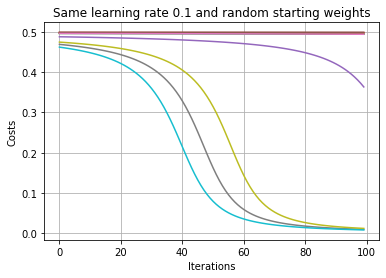

In [40]:
J1 = train_ann_example(0.1, 100)
J2 = train_ann_example(0.1, 100)
J3 = train_ann_example(0.1, 100)
J4 = train_ann_example(0.1, 100)
J5 = train_ann_example(0.1, 100)
J6 = train_ann_example(0.1, 100)
J7 = train_ann_example(0.1, 100)
J8 = train_ann_example(0.1, 100)
J9 = train_ann_example(0.1, 100)
J10 = train_ann_example(0.1, 100)

fig, ax = plt.subplots()
ax.plot(range(100), J1, range(100), J2, range(100), J3, range(100), J4, range(100), J5, range(100), J6, range(100), J7, range(100), J8, range(100), J9, range(100), J10)
plt.xlabel('Iterations')
plt.ylabel('Costs')
plt.title('Same learning rate 0.1 and random starting weights')
plt.grid(True)

What do you learn of the plotted chart? In my case, I see that all the cost functions are different. Three of the ten cost functions becomes almost zero after 60 iterations. One cost function starts learning at 90 iterations. The rest, 6 cost functions, do not show any learnings. You can re-run the code to get other charts. I conclude that everytime the learning is different. It is even possible that learning does not occur. Re-run the ANN is good to do to see whether learning occurs. From one trial it is difficult to conclude that a network is not correct.

### Learning rate 0.5 and 100 iterations

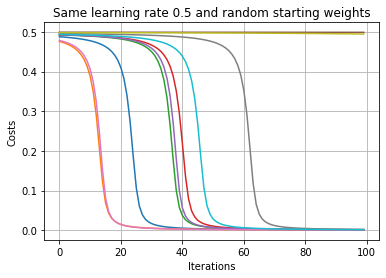

In [41]:
J1 = train_ann_example(0.5, 100)
J2 = train_ann_example(0.5, 100)
J3 = train_ann_example(0.5, 100)
J4 = train_ann_example(0.5, 100)
J5 = train_ann_example(0.5, 100)
J6 = train_ann_example(0.5, 100)
J7 = train_ann_example(0.5, 100)
J8 = train_ann_example(0.5, 100)
J9 = train_ann_example(0.5, 100)
J10 = train_ann_example(0.5, 100)

fig, ax = plt.subplots()
ax.plot(range(100), J1, range(100), J2, range(100), J3, range(100), J4, range(100), J5, range(100), J6, range(100), J7, range(100), J8, range(100), J9, range(100), J10)
plt.xlabel('Iterations')
plt.ylabel('Costs')
plt.title('Same learning rate 0.5 and random starting weights')
plt.grid(True)

The learning rate is large. Normally we will se learning rates of 0.01. In my chart I see that 8 cost function find a good solution. Two of these cost function find the optimum after 20 iterations and slowest one after 60 iterations. It is interesting to see that two cost functions do not show any learning, so that is even possible! What I conclude from this chart, is that learning is alway different. In one case, the learning is done after 20 iterations and in another after 70. The learning takes three times longer. During training you need to take this difference into account. An important aspect is that for the eight cost functions we see that the cost function is decreasing in the beginnen slowly.

### Learning rate 5 and 100 iterations

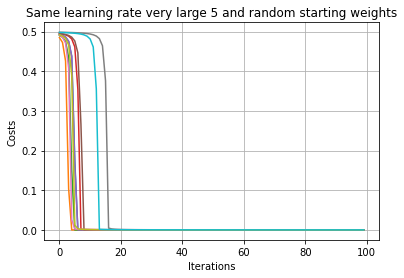

In [42]:
J1 = train_ann_example(5, 100)
J2 = train_ann_example(5, 100)
J3 = train_ann_example(5, 100)
J4 = train_ann_example(5, 100)
J5 = train_ann_example(5, 100)
J6 = train_ann_example(5, 100)
J7 = train_ann_example(5, 100)
J8 = train_ann_example(5, 100)
J9 = train_ann_example(5, 100)
J10 = train_ann_example(5, 100)

fig, ax = plt.subplots()
ax.plot(range(100), J1, range(100), J2, range(100), J3, range(100), J4, range(100), J5, range(100), J6, range(100), J7, range(100), J8, range(100), J9, range(100), J10)
plt.xlabel('Iterations')
plt.ylabel('Costs')
plt.title('Same learning rate very large 5 and random starting weights')
plt.grid(True)

A ridicoulous learning rate. Most probably in a real situation this will not lead to any solutions. However, I see all ten cost functions in the chart that find an optimal solution before the 20 iterations. What we still see is that we have ten different cost functions.

### Learning reate 0.01 and 5.000 iterations

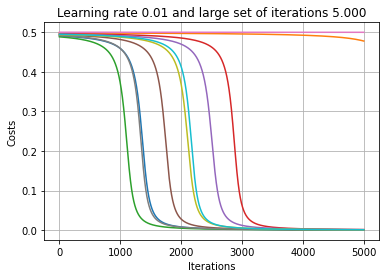

In [44]:
J1 = train_ann_example(0.01, 5000)
J2 = train_ann_example(0.01, 5000)
J3 = train_ann_example(0.01, 5000)
J4 = train_ann_example(0.01, 5000)
J5 = train_ann_example(0.01, 5000)
J6 = train_ann_example(0.01, 5000)
J7 = train_ann_example(0.01, 5000)
J8 = train_ann_example(0.01, 5000)
J9 = train_ann_example(0.01, 5000)
J10 = train_ann_example(0.01, 5000)

fig, ax = plt.subplots()
ax.plot(range(5000), J1, range(5000), J2, range(5000), J3, range(5000), J4, range(5000), J5, range(5000), J6, range(5000), J7, range(5000), J8, range(5000), J9, range(5000), J10)
plt.xlabel('Iterations')
plt.ylabel('Costs')
plt.title('Learning rate 0.01 and large set of iterations 5.000')
plt.grid(True)

While it takes al little bit longer. A learning rate of 0.01 is cery common for gradient descent. In my case, nine cost functions go to zero and therefore the algorithm found an optimal solution. Except for one cost function that shows no learning. There is still a large deviation. The first cost function goes before 1.000 iterations to zero. The slowest goes to zero after 3.000.

### Learning rate 0.01 and 5.000 iterations with a very complex ANN

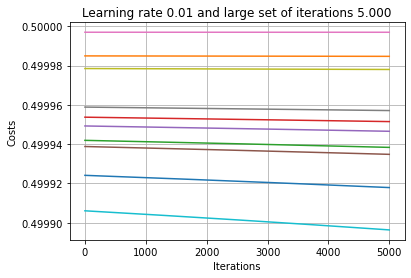

In [46]:
J1 = train_ann_example_complex(0.01, 5000)
J2 = train_ann_example_complex(0.01, 5000)
J3 = train_ann_example_complex(0.01, 5000)
J4 = train_ann_example_complex(0.01, 5000)
J5 = train_ann_example_complex(0.01, 5000)
J6 = train_ann_example_complex(0.01, 5000)
J7 = train_ann_example_complex(0.01, 5000)
J8 = train_ann_example_complex(0.01, 5000)
J9 = train_ann_example_complex(0.01, 5000)
J10 = train_ann_example_complex(0.01, 5000)

fig, ax = plt.subplots()
ax.plot(range(5000), J1, range(5000), J2, range(5000), J3, range(5000), J4, range(5000), J5, range(5000), J6, range(5000), J7, range(5000), J8, range(5000), J9, range(5000), J10)
plt.xlabel('Iterations')
plt.ylabel('Costs')
plt.title('Learning rate 0.01 and large set of iterations 5.000')
plt.grid(True)

My chart shows no cost function that has learned something. All ten stay around 0.5. The network is too complex and learning will stop eventually.

## Conclusion
Put in your portfolio the learning of these examples that helps you during the training of the real thing! Good luck!